# Satellite Cloud and Rain visual demo

*Running with flc_env on smiller2 machine*

**Libraries needed:**

In [1]:
#---Cloud search libraries
import s3fs #---The installation of this package on conda makes me nervous for the environment stability
import requests
import fnmatch

#---Accessory libraries
import datetime
import xarray as xr
import netCDF4
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as feature
import pandas as pd

**Set the datetime to view:**

In [2]:
year = 2024
month = 12
day = 28
hour = 23

julian_day = datetime.datetime(year, month, day).strftime('%j')
print(julian_day)

datetime_str = str(year)+'-'+str(month).zfill(2)+'-'+str(day).zfill(2)+' '+str(hour).zfill(2)+'Z'
print(datetime_str)

363
2024-12-28 23Z


**Select region for visualization:**

In [3]:
#--- US CONUS region
latitude_north = 50
latitude_south = 24
longitude_west = -125
longitude_east = -66

**Connecting to AWS remote storage:**

In [4]:
fs = s3fs.S3FileSystem(anon=True)

**Search the AWS database:**

Abbreviations for ABI total precipitable water products:
* https://www.star.nesdis.noaa.gov/atmospheric-composition-training/python_abi_level2_download.php

In [5]:
bucket = 'noaa-goes16'
product = 'ABI-L2-TPWF' #---Total precipitable water


data_path = bucket + '/' + product + '/'  + str(year) + '/' + julian_day + '/' + str(hour).zfill(2)

files = fs.ls(data_path)

for f in files: 
    print(f)

noaa-goes16/ABI-L2-TPWF/2024/363/23/OR_ABI-L2-TPWF-M6_G16_s20243632300204_e20243632309512_c20243632311408.nc
noaa-goes16/ABI-L2-TPWF/2024/363/23/OR_ABI-L2-TPWF-M6_G16_s20243632310204_e20243632319512_c20243632321268.nc
noaa-goes16/ABI-L2-TPWF/2024/363/23/OR_ABI-L2-TPWF-M6_G16_s20243632320204_e20243632329512_c20243632331336.nc
noaa-goes16/ABI-L2-TPWF/2024/363/23/OR_ABI-L2-TPWF-M6_G16_s20243632330204_e20243632339512_c20243632341225.nc
noaa-goes16/ABI-L2-TPWF/2024/363/23/OR_ABI-L2-TPWF-M6_G16_s20243632340204_e20243632349512_c20243632351311.nc
noaa-goes16/ABI-L2-TPWF/2024/363/23/OR_ABI-L2-TPWF-M6_G16_s20243632350204_e20243632359512_c20243640001282.nc


In [6]:
#--- Using the top-of-the-hour
file = files[0]

In [7]:
resp = requests.get(f'https://'+bucket+'.s3.amazonaws.com/'+file[12:])
if str(resp) != '<Response [200]>':
    print('file not found in AWS servers')

**Open the satellite data:**

In [8]:
nc = netCDF4.Dataset(file, memory = resp.content)
ds = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))

**Get the latitudes and longitudes for the satellite image:**

In [9]:
def calc_latlon(ds):
    # The math for this function was taken from 
    # https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm
    x = ds.x
    y = ds.y
    goes_imager_projection = ds.goes_imager_projection
    
    x,y = np.meshgrid(x,y)
    
    r_eq = goes_imager_projection.attrs["semi_major_axis"]
    r_pol = goes_imager_projection.attrs["semi_minor_axis"]
    l_0 = goes_imager_projection.attrs["longitude_of_projection_origin"] * (np.pi/180)
    h_sat = goes_imager_projection.attrs["perspective_point_height"]
    H = r_eq + h_sat
    
    a = np.sin(x)**2 + (np.cos(x)**2 * (np.cos(y)**2 + (r_eq**2 / r_pol**2) * np.sin(y)**2))
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - r_eq**2
    
    #--- Added absolute to remove error
    r_s = (-b - np.sqrt(np.absolute(b**2 - 4*a*c)))/(2*a)
    
    s_x = r_s * np.cos(x) * np.cos(y)
    s_y = -r_s * np.sin(x)
    s_z = r_s * np.cos(x) * np.sin(y)
    
    lat = np.arctan((r_eq**2 / r_pol**2) * (s_z / np.sqrt((H-s_x)**2 +s_y**2))) * (180/np.pi)
    lon = (l_0 - np.arctan(s_y / (H-s_x))) * (180/np.pi)
    
    ds = ds.assign_coords({
        "lat":(["y","x"],lat),
        "lon":(["y","x"],lon)
    })
    ds.lat.attrs["units"] = "degrees_north"
    ds.lon.attrs["units"] = "degrees_east"
    return ds



def get_xy_from_latlon(ds, lats, lons):
    lat1, lat2 = lats
    lon1, lon2 = lons

    lat = ds.lat.data
    lon = ds.lon.data
    
    x = ds.x.data
    y = ds.y.data
    
    x,y = np.meshgrid(x,y)
    
    x = x[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)]
    y = y[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)] 
    
    return ((min(x), max(x)), (min(y), max(y)))

In [10]:
ds_lat_lon = calc_latlon(ds)
((x1,x2), (y1, y2)) = get_xy_from_latlon(ds_lat_lon, (latitude_south, latitude_north), (longitude_west, longitude_east))
region = ds_lat_lon.sel(x=slice(x1, x2), y=slice(y2, y1))


**Create the strings for the save file:**

In [11]:
date_str = str(datetime_str).replace('-', '_').replace(' ', '_')

**Plot the figure:**

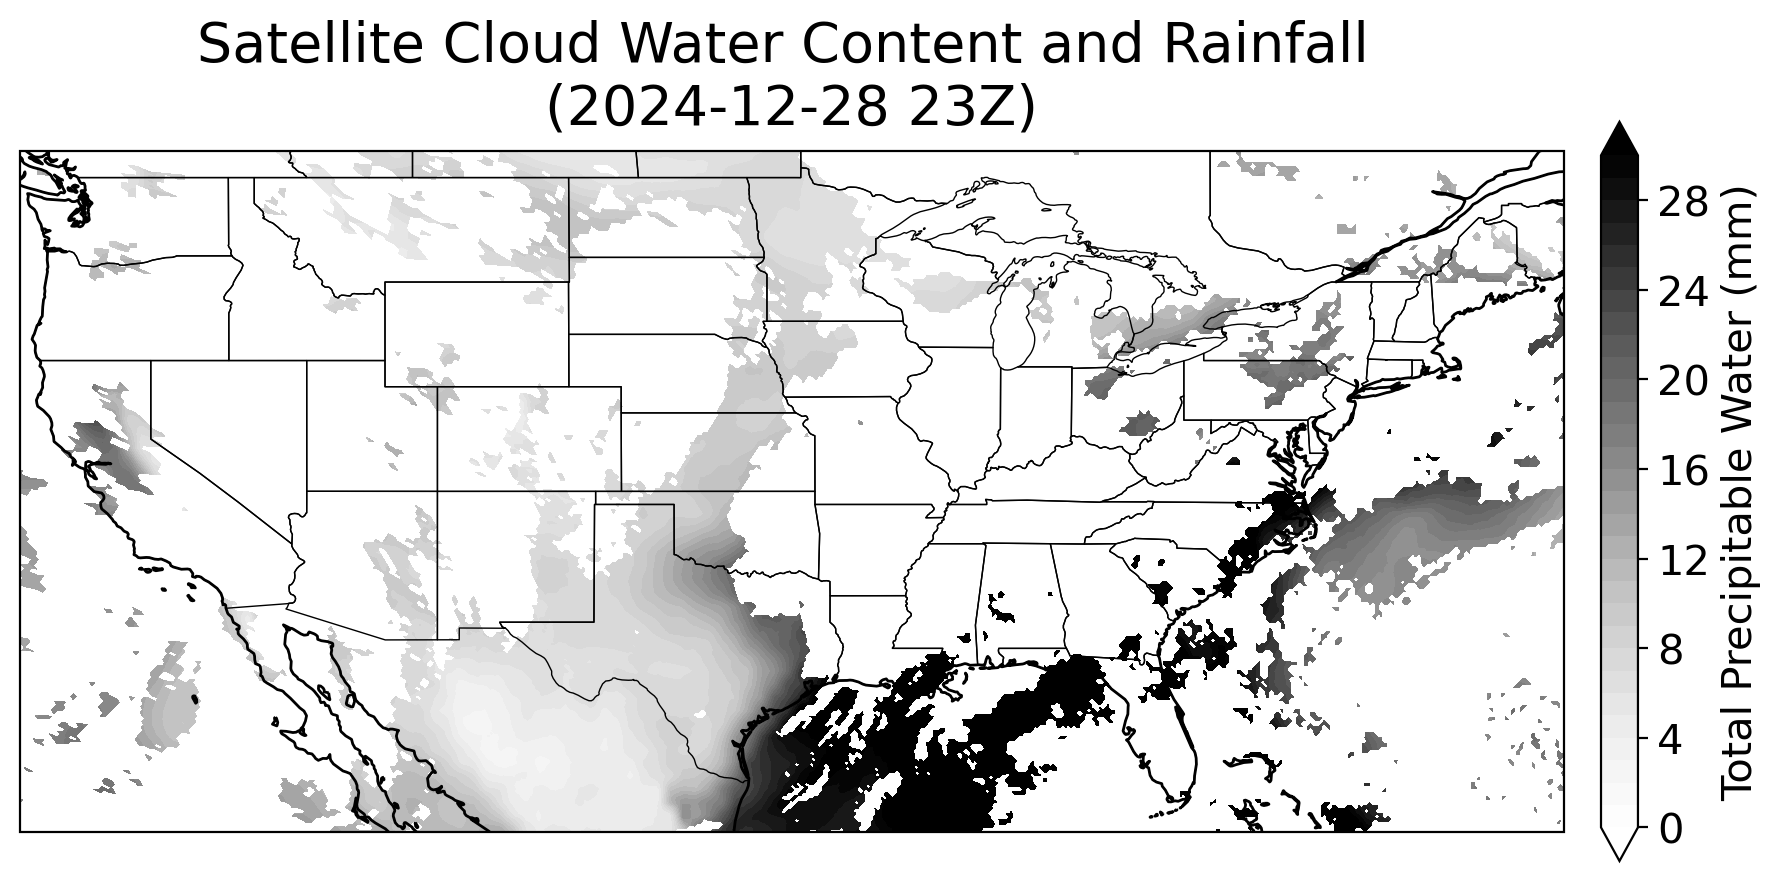

In [12]:

projection=ccrs.PlateCarree(central_longitude=0)

fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})


levels = np.linspace(0, 30, 31)
c=ax.contourf(ds_lat_lon.lon, ds_lat_lon.lat, ds_lat_lon.TPW, cmap='Greys', extend='both', levels=levels)


clb = plt.colorbar(c, shrink=0.4, pad=0.02, ax=ax)
clb.ax.tick_params(labelsize=15)
clb.set_label('Total Precipitable Water (mm)', fontsize=15)

ax.set_extent([longitude_west, longitude_east, latitude_south, latitude_north], crs=ccrs.PlateCarree())

ax.set_title("Satellite Cloud Water Content and Rainfall \n("+datetime_str+")", fontsize=20, pad=10)
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.add_feature(feature.STATES, zorder=100, edgecolor='#000', facecolor='none', linewidth=0.5)

fig.set_dpi(200)
fig.show()

**Loading the cocorahs data:**

In [13]:
cocorahs_path = "cocorahs/"+str(month)+str(day)+str(year)

cocorahs_df = pd.read_xml(cocorahs_path, xpath=".//DailyPrecipReport")

In [14]:
cocorahs_df

,ObservationDate,ObservationTime,EntryDateTime,StationNumber,StationName,Latitude,Longitude,TotalPrecipAmt,NewSnowDepth,SnowCorePrecipAmt,TotalSnowDepth,TotalSnowSWE,DateTimeStamp
0,2024-12-28,02:00 PM,2024-12-28 03:06 PM,NM-BR-17,Albuquerque 8 NE,35.186100,-106.507100,0.00,0.0,NaN,NaN,NaN,2024-12-28 03:06 PM
1,2024-12-28,03:00 PM,2024-12-28 10:37 PM,CO-LR-623,Fort Collins 5.4 WSW,40.518589,-105.158975,0.00,0.0,NaN,NaN,NaN,2024-12-28 10:37 PM
2,2024-12-28,01:00 PM,2024-12-28 02:59 PM,KS-DC-2,Norcatur 4.4 S,39.770400,-100.181300,0.00,0.0,NaN,0.0,NaN,2024-12-28 02:59 PM
3,2024-12-28,03:00 PM,2024-12-29 02:43 AM,NM-TS-1,Arroyo Hondo 4.8 WSW,36.509700,-105.750400,T,T,NaN,NaN,NaN,2024-12-29 02:43 AM
4,2024-12-28,02:00 PM,2024-12-28 02:28 PM,NM-DA-46,Las Cruces 6.3 W,32.320581,-106.862350,0.00,0.0,NaN,NaN,NaN,2024-12-28 02:28 PM
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12964,2024-12-28,01:00 PM,2024-12-28 02:12 PM,OK-JC-17,Blair 2.4 S,34.744132,-99.335363,0.00,0.0,NaN,NaN,NaN,2024-12-28 02:11 PM
12965,2024-12-28,03:00 PM,2024-12-28 03:09 PM,WA-KG-318,Des Moines 2.3 NNW,47.425449,-122.329733,0.52,NaN,NaN,NaN,NaN,2024-12-28 03:09 PM
12966,2024-12-28,12:00 PM,2024-12-28 10:13 PM,WI-DA-188,Middleton 2.2 S,43.071179,-89.507953,0.53,NaN,NaN,NaN,NaN,2024-12-28 10:13 PM
12967,2024-12-28,02:40 PM,2024-12-28 02:49 PM,FL-ES-73,Pensacola 7.3 WSW,30.418000,-87.308000,2.23,NaN,NaN,NaN,NaN,2024-12-28 02:48 PM


**Adding a datetime to the cocorahs data:**

In [15]:
cocorahs_df['ObservationDate'] = pd.to_datetime(cocorahs_df['ObservationDate'], format='%Y-%m-%d')
cocorahs_df['ObservationTime'] = pd.to_datetime(cocorahs_df['ObservationTime'], format='%I:%M %p').dt.time
cocorahs_df['ObservationDatetime'] = pd.to_datetime(cocorahs_df['ObservationDate'].astype(str) + ' ' + cocorahs_df['ObservationTime'].astype(str))


In [16]:
cocorahs_df_hour = cocorahs_df[cocorahs_df['ObservationTime'].apply(lambda x: x.hour == hour)]


In [17]:
cocorahs_df_hour

,ObservationDate,ObservationTime,EntryDateTime,StationNumber,StationName,Latitude,Longitude,TotalPrecipAmt,NewSnowDepth,SnowCorePrecipAmt,TotalSnowDepth,TotalSnowSWE,DateTimeStamp,ObservationDatetime
827,2024-12-28,23:30:00,2024-12-28 11:37 PM,IN-LW-8,Bedford 8.6 NNW,38.971603,-86.561600,0.26,NaN,NaN,NaN,NaN,2024-12-28 11:36 PM,2024-12-28 23:30:00
1249,2024-12-28,23:00:00,2024-12-28 11:06 PM,AL-WK-4,Jasper 3.4 SE,33.824470,-87.220870,0.28,0.0,NaN,NaN,NaN,2024-12-28 11:05 PM,2024-12-28 23:00:00
2039,2024-12-28,23:00:00,2024-12-28 11:31 PM,IN-LK-50,Hobart 1.6 E,41.535100,-87.236200,0.07,NaN,NaN,NaN,NaN,2024-12-28 11:31 PM,2024-12-28 23:00:00
3128,2024-12-28,23:25:00,2024-12-28 11:26 PM,AR-SH-3,Evening Shade 2.7 SSE,36.037336,-91.595356,0.57,NaN,NaN,NaN,NaN,2024-12-28 11:26 PM,2024-12-28 23:25:00
4980,2024-12-28,23:15:00,2024-12-28 11:26 PM,TX-CSS-6,Jefferson 9.1 N,32.891700,-94.329400,2.10,NaN,NaN,NaN,NaN,2024-12-28 11:26 PM,2024-12-28 23:15:00
6399,2024-12-28,23:00:00,2024-12-28 10:10 PM,GA-TN-4,Collins 7.3 NNE,32.268890,-82.044280,0.00,0.0,NaN,NaN,NaN,2024-12-28 10:10 PM,2024-12-28 23:00:00
6419,2024-12-28,23:31:00,2024-12-28 11:33 PM,TX-LE-21,Giddings 10.4 SSW,30.055700,-97.018700,0.10,NaN,NaN,NaN,NaN,2024-12-28 11:33 PM,2024-12-28 23:31:00
6510,2024-12-28,23:30:00,2024-12-29 12:06 AM,TX-HYS-205,Buda 1.9 WNW,30.091418,-97.870551,0.23,NaN,NaN,NaN,NaN,2024-12-29 12:05 AM,2024-12-28 23:30:00
8682,2024-12-28,23:00:00,2024-12-28 11:21 PM,TX-LL-65,Horseshoe Bay 1.7 N,30.561746,-98.359245,0.00,0.0,NaN,NaN,NaN,2024-12-28 11:20 PM,2024-12-28 23:00:00
9183,2024-12-28,23:00:00,2024-12-29 02:18 AM,NY-OD-67,Holland Patent 0.6 SSE,43.232940,-75.253690,0.00,0.0,NaN,NaN,NaN,2024-12-29 02:18 AM,2024-12-28 23:00:00


**Filtering out zeroes from the precip amounts:**

In [18]:
cocorahs_df_hour = cocorahs_df_hour.copy()
cocorahs_df_hour['TotalPrecipAmt'] = pd.to_numeric(cocorahs_df_hour['TotalPrecipAmt'], errors='coerce')
cocorahs_df_cleaned = cocorahs_df_hour.dropna(subset=['TotalPrecipAmt']).copy()
cocorahs_df_cleaned = cocorahs_df_cleaned[cocorahs_df_cleaned['TotalPrecipAmt'] != 0].copy()

**Plot the figure with clouds and precip:**

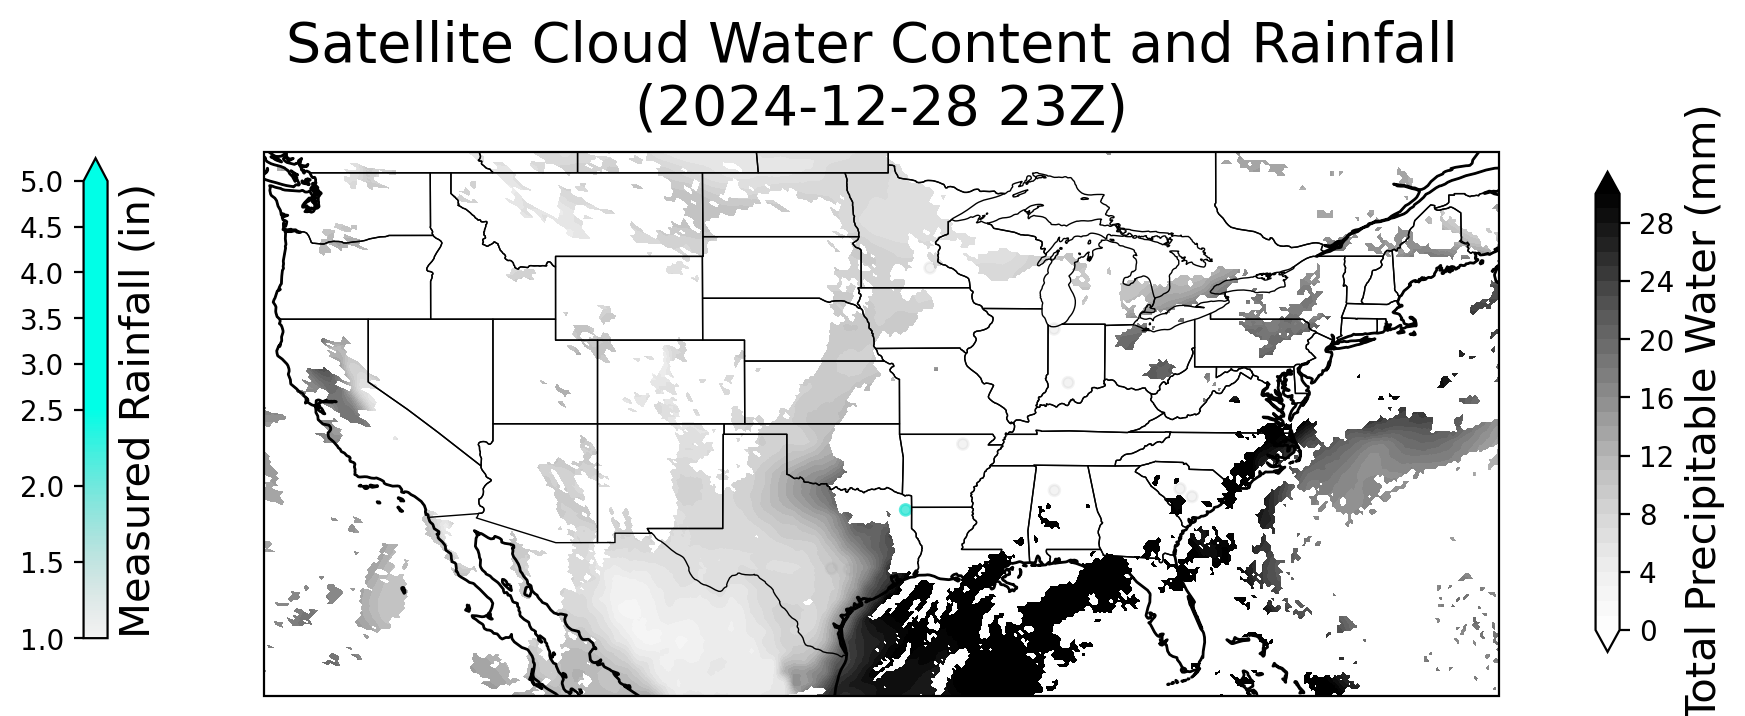

In [19]:
projection=ccrs.PlateCarree(central_longitude=0)

fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})


#--- Total precipitable water
levels = np.linspace(0, 30, 31)
c=ax.contourf(ds_lat_lon.lon, ds_lat_lon.lat, ds_lat_lon.TPW, cmap='Greys', extend='both', levels=levels)

clb = plt.colorbar(c, shrink=0.4, pad=0.02, ax=ax)
#clb.ax.tick_params(labelsize=15)
clb.set_label('Total Precipitable Water (mm)', fontsize=15)
clb.ax.set_position([0.68, 0.1, 0.01, 0.8])

#--- Cocorahs measured rainfall
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#A0A0A020', '#00FFE7', '#00FFE7'])
norm = TwoSlopeNorm(vmin=1, vcenter=2.5, vmax=5)

scatter = ax.scatter(cocorahs_df_cleaned.Longitude, cocorahs_df_cleaned.Latitude, c=cocorahs_df_cleaned.TotalPrecipAmt, cmap=cmap, norm=norm, s=15, transform=ccrs.PlateCarree())
clb_scatter = plt.colorbar(scatter, ax=ax, extend='max')
clb_scatter.ax.yaxis.set_ticks_position('left')
clb_scatter.set_label('Measured Rainfall (in)', fontsize=15)
clb_scatter.ax.set_position([0.05, 0.12, 0.01, 0.8])

ax.set_extent([longitude_west, longitude_east, latitude_south, latitude_north], crs=ccrs.PlateCarree())

ax.set_title("Satellite Cloud Water Content and Rainfall \n("+datetime_str+")", fontsize=20, pad=10)
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.add_feature(feature.STATES, zorder=100, edgecolor='#000', facecolor='none', linewidth=0.5)

fig.set_dpi(200)
fig.savefig("animation/cloud_rain_"+date_str, dpi=200, bbox_inches='tight')
fig.show()